In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Set Random Seed
from numpy.random import seed
seed(100)
tf.compat.v1.set_random_seed(100)

In [2]:
# Load dataset
data = pd.read_csv('./iris.csv')
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#Create x and y variables
X = data.drop('species', axis=1)
y = data['species']

from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
y = le.fit_transform(y)

#Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#Scale the Data
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train)
X_test2 = sc.fit_transform(X_test)

In [4]:
#Create Base Model

from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import backend as K

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(4, input_shape=[len(X.keys())], kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2,seed=100))
    model.add(Dense(2, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2,seed=100))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


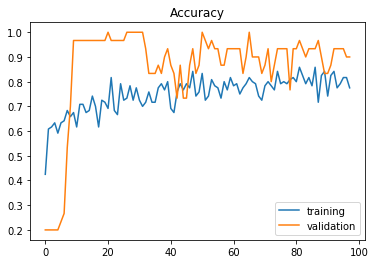

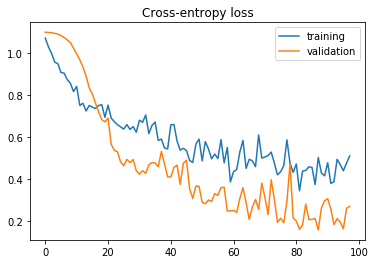


# Evaluate on test data
Train loss: 0.18, Train Acc: 0.94
Test loss: 0.27, Test Acc: 0.90


In [5]:
#Evaluate Model
model=create_baseline()
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train2,y_train, epochs=100,
                    validation_data=(X_test2, y_test),
                    verbose=0,batch_size = 5,callbacks=[early_stop])

#Plot
def plot_accuracies_and_losses(history):
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training', 'validation'], loc='best')
    plt.show()
   
    plt.title('Cross-entropy loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

plot_accuracies_and_losses(history)

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
resultsTst = model.evaluate(X_test2, y_test,verbose=0)
resultsTrn = model.evaluate(X_train2, y_train,verbose=0)
print('Train loss: {:.2f}, Train Acc: {:.2f}'.format(resultsTrn[0],resultsTrn[1])) 
print('Test loss: {:.2f}, Test Acc: {:.2f}'.format(resultsTst[0],resultsTst[1])) 

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

#Key Metrics

# predict probabilities for test set
yhat_probs = model.predict(X_test2, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test2, verbose=0)

#Create Matrix
print('Confusion and Classification Matrix')
print('\n')
matrix = confusion_matrix(y_test, yhat_classes)
target_names=['setosa','versicolor','virginica']
cr = classification_report(y_test, yhat_classes,target_names=target_names)
print(matrix)
print(cr)

Confusion and Classification Matrix


[[11  0  0]
 [ 0  6  0]
 [ 0  3 10]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       0.67      1.00      0.80         6
   virginica       1.00      0.77      0.87        13

    accuracy                           0.90        30
   macro avg       0.89      0.92      0.89        30
weighted avg       0.93      0.90      0.90        30



In [7]:
# Evaluate model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=100)
results = cross_val_score(pipeline, X, y, cv=kfold)
print('CV-Accuracy: {:.0f}%'.format(results.mean()*100)) 

CV-Accuracy: 95%
